# Análise de Fatores de Vitória nos Mundiais de League of Legends (2020-2022)

## Introdução

Este projeto tem como objetivo realizar uma análise exploratória dos dados dos campeonatos mundiais de League of Legends dos anos de 2020, 2021 e 2022. O foco é identificar os principais fatores e estratégias que se correlacionam com o sucesso das equipes no mais alto nível competitivo.

Buscaremos responder às seguintes perguntas:
1.  Quais estatísticas de jogo (ouro, objetivos, abates) têm maior impacto no número de vitórias de um time?
2.  Existem "mitos" ou crenças populares sobre o jogo que não se sustentam nos dados profissionais?
3.  Como as estratégias vencedoras podem ter evoluído ao longo desses três anos?

**Fonte dos Dados:**
Os dados foram obtidos através do Kaggle, utilizando os seguintes datasets:
* [League of Legends World Championship 2020](https://www.kaggle.com/datasets/ilyadziamidovich/league-of-legends-world-championship-2020)
* [League of Legends World Championship 2021](https://www.kaggle.com/datasets/ilyadziamidovich/league-of-legends-world-championship-2021)
* [League of Legends World Championship 2022](https://www.kaggle.com/datasets/ilyadziamidovich/league-of-legends-world-championship-2022)

## Passo 1: Configuração e Carregamento dos Dados

Nesta etapa, vamos configurar nosso ambiente, instalar as bibliotecas necessárias e carregar os dados. Usaremos a biblioteca `kagglehub` para baixar os datasets diretamente do Kaggle, garantindo a replicabilidade do projeto. Em seguida, faremos o carregamento dos arquivos CSV de estatísticas de times para a memória.

In [ ]:
# Instala o kagglehub caso ainda não esteja instalado
!pip install kagglehub -q

import kagglehub
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

print("--- PASSO 1: BAIXANDO OS DATASETS ---")
path_2020 = kagglehub.dataset_download("ilyadziamidovich/league-of-legends-world-championship-2020")
path_2021 = kagglehub.dataset_download("ilyadziamidovich/league-of-legends-world-championship-2021")
path_2022 = kagglehub.dataset_download("ilyadziamidovich/league-of-legends-world-championship-2022")

print("\n--- PASSO 2: ENCONTRANDO E CARREGANDO OS ARQUIVOS DE TIMES ---")
dataframes = {}
paths_by_year = {'2020': path_2020, '2021': path_2021, '2022': path_2022}

for year, path in paths_by_year.items():
    team_files = glob.glob(os.path.join(path, '*teams*.csv'))
    print(f"\nArquivos de times encontrados em '{path}':")
    if not team_files:
        print(" -> Nenhum arquivo de times encontrado.")
        continue
    for file_path in team_files:
        file_name = os.path.basename(file_path)
        df_name = f"df_{year}_{'teams_main' if 'main' in file_name else 'teams_play_in'}"
        try:
            dataframes[df_name] = pd.read_csv(file_path)
            print(f" -> Arquivo '{file_name}' carregado com sucesso como '{df_name}'.")
        except Exception as e:
            print(f" -> ERRO ao carregar '{file_name}': {e}")

--- PASSO 1: BAIXANDO OS DATASETS ---

--- PASSO 2: ENCONTRANDO E CARREGANDO OS ARQUIVOS DE TIMES ---

Arquivos de times encontrados em '/kaggle/input/league-of-legends-world-championship-2020':
 -> Arquivo 'wc_teams_main.csv' carregado com sucesso como 'df_2020_teams_main'.
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2020_teams_play_in'.

Arquivos de times encontrados em '/kaggle/input/league-of-legends-world-championship-2021':
 -> Arquivo 'wc_teams_main.csv' carregado com sucesso como 'df_2021_teams_main'.
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2021_teams_play_in'.

Arquivos de times encontrados em '/kaggle/input/league-of-legends-world-championship-2022':
 -> Arquivo 'wc_teams_main.csv' carregado com sucesso como 'df_2022_teams_main'.
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2022_teams_play_in'.


## Passo 2: Limpeza e Consolidação dos Dados

Com os dados carregados, o próximo passo é crucial: a limpeza e unificação. Os dados de cada ano estão separados em fases (`Play-In` e `Main Stage`). Além disso, muitas colunas que representam taxas (como "50%") estão formatadas como texto e precisam ser convertidas para números para que possamos realizar cálculos.

Neste passo, vamos:
1.  Unir os dataframes de `Play-In` e `Main Stage` para cada ano.
2.  Adicionar uma coluna `year` para identificar o torneio de cada registro.
3.  Concatenar os dados dos três anos em um único DataFrame mestre: `df_teams_full`.
4.  Converter colunas de porcentagem para o formato numérico (float).
5.  Realizar pequenas correções e renomear colunas para maior clareza.

In [ ]:
print("--- UNIFICANDO E LIMPANDO OS DADOS DE TIMES ---")

yearly_dfs = []
for year in [2020, 2021, 2022]:
    df_play_in = dataframes[f'df_{year}_teams_play_in']
    df_main = dataframes[f'df_{year}_teams_main']

    df_play_in['stage'] = 'Play-In'
    df_main['stage'] = 'Main Stage'

    df_year_combined = pd.concat([df_play_in, df_main], ignore_index=True)
    df_year_combined['year'] = year
    yearly_dfs.append(df_year_combined)

df_teams_full = pd.concat(yearly_dfs, ignore_index=True)
print("-> Dados de todos os anos combinados.")

cols_to_clean = [col for col in df_teams_full.columns if 'rate' in col or 'control' in col]
cols_to_clean.append('gold_spent_difference')

for col in cols_to_clean:
    if df_teams_full[col].dtype == 'object':
        df_teams_full[col] = pd.to_numeric(df_teams_full[col].str.replace('%', ''), errors='coerce') / 100

print("-> Colunas de porcentagem e controle convertidas para formato numérico.")

df_teams_full.rename(columns={'loses': 'losses'}, inplace=True)
print("-> Coluna 'loses' renomeada para 'losses'.")

print("\n--- VERIFICANDO O DATAFRAME FINAL ---")
df_teams_full.info()

--- UNIFICANDO E LIMPANDO OS DADOS DE TIMES ---
-> Dados de todos os anos combinados.
-> Colunas de porcentagem e controle convertidas para formato numérico.
-> Coluna 'loses' renomeada para 'losses'.

--- VERIFICANDO O DATAFRAME FINAL ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   team                        80 non-null     object 
 1   games_played                80 non-null     int64  
 2   wins                        80 non-null     int64  
 3   losses                      80 non-null     int64  
 4   average_game_duration       80 non-null     float64
 5   kills                       80 non-null     int64  
 6   deaths                      80 non-null     int64  
 7   kd                          80 non-null     float64
 8   combined_kills_per_minute   80 non-null     float64
 9   gold_percent_rating      

## Passo 3: Análise Exploratória - Quais Fatores mais se Correlacionam com Vitórias?

Agora que nossa base de dados está limpa e unificada, podemos começar a extrair insights. A primeira e mais importante pergunta é: o que, estatisticamente, leva um time à vitória?

Para responder a isso, calcularemos a **correlação de Pearson** entre todas as métricas numéricas e a coluna `wins` (vitórias). Isso nos mostrará quais fatores têm a maior associação positiva com o ato de vencer. Em seguida, visualizaremos esses resultados em um gráfico de barras para facilitar a interpretação.

--- ANÁLISE 1: CORRELAÇÃO DE MÉTRICAS COM VITÓRIAS ---


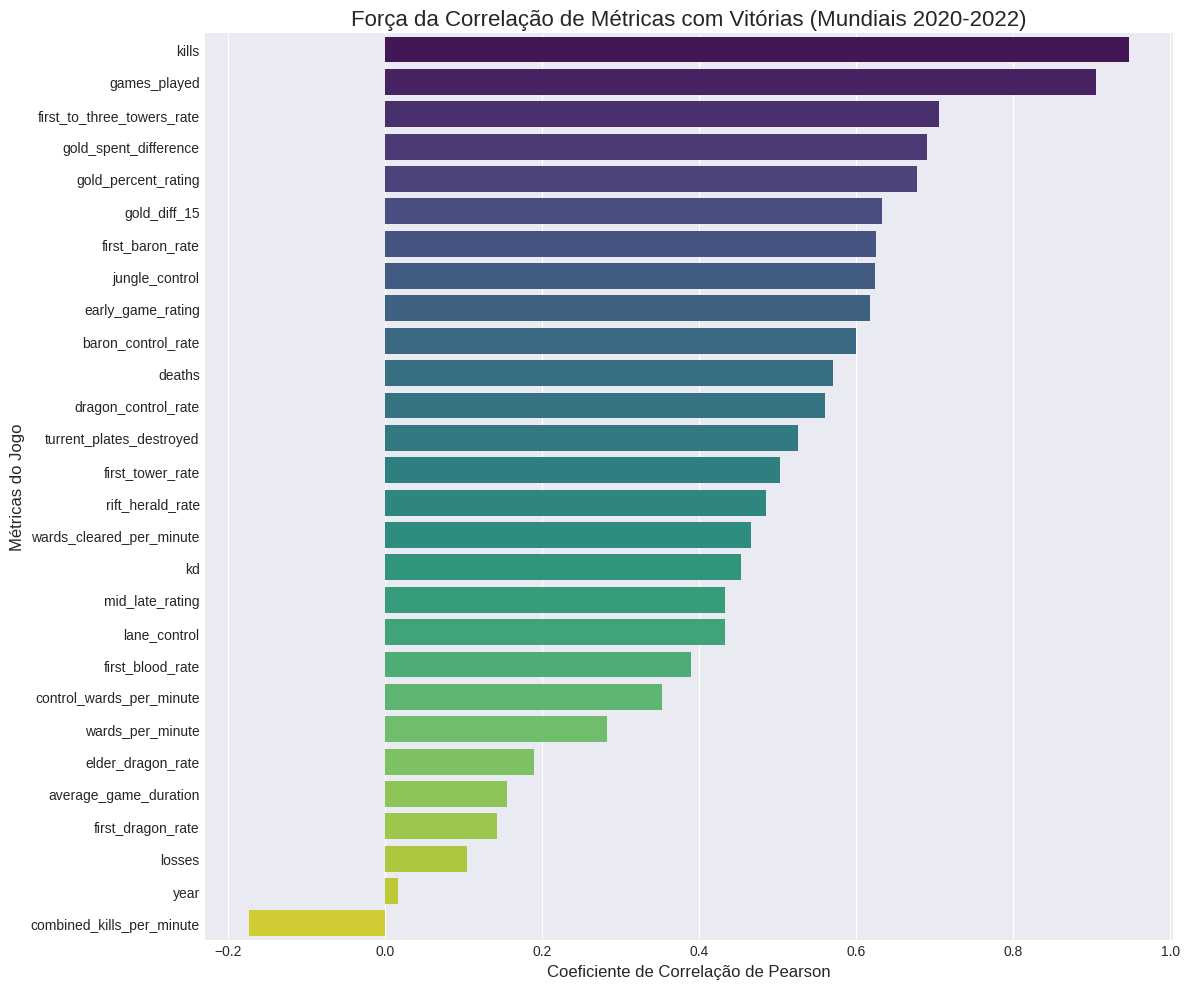

In [ ]:
print("--- ANÁLISE 1: CORRELAÇÃO DE MÉTRICAS COM VITÓRIAS ---")

# Seleciona apenas as colunas numéricas
df_numeric = df_teams_full.select_dtypes(include=np.number)

# Calcula a matriz de correlação
correlation_matrix = df_numeric.corr()

# Pega a correlação de todas as métricas com a coluna 'wins' e ordena
corr_with_wins = correlation_matrix['wins'].sort_values(ascending=False)

# Remove a própria correlação (que é sempre 1)
corr_with_wins = corr_with_wins.drop('wins')

# --- CRIAÇÃO DO GRÁFICO ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 10))

# Cria o gráfico de barras
sns.barplot(x=corr_with_wins.values, y=corr_with_wins.index, palette='viridis')

# Adiciona títulos e rótulos
plt.title('Força da Correlação de Métricas com Vitórias (Mundiais 2020-2022)', fontsize=16)
plt.xlabel('Coeficiente de Correlação de Pearson', fontsize=12)
plt.ylabel('Métricas do Jogo', fontsize=12)

# Exibe o gráfico
plt.tight_layout()
plt.show()

## Interpretação dos Resultados da Análise de Correlação

O gráfico acima nos fornece uma visão clara sobre o que é mais importante para alcançar a vitória nos mundiais de League of Legends.

### Principais Insights: O Caminho para a Vitória 🏆
* **O Ouro é Rei:** As métricas relacionadas a ouro (`gold_spent_difference`, `gold_percent_rating`, `gold_diff_15`) possuem uma correlação extremamente alta com as vitórias. Em especial, a **diferença de ouro aos 15 minutos (`gold_diff_15`)** se destaca, indicando que construir uma vantagem no início do jogo é um dos mais fortes preditores de sucesso.
* **Pressão de Mapa e Objetivos Maiores:** Conquistar as **três primeiras torres (`first_to_three_towers_rate`)** e garantir o **primeiro Barão (`first_baron_rate`)** são as estratégias com maior impacto, superando até mesmo algumas métricas de ouro. Isso demonstra que saber usar a vantagem econômica para controlar o mapa é o que diferencia as equipes de elite.

### Descobertas Surpreendentes (e Ótimas para o Portfólio!) 🤔
* **O Mito do Primeiro Dragão:** A taxa de conquista do primeiro dragão (`first_dragon_rate`) tem uma correlação surpreendentemente **baixa** com a vitória. Isso sugere que, no nível profissional, este objetivo pode ser frequentemente trocado por vantagens consideradas mais importantes em outras partes do mapa, como o Arauto do Vale.
* **O "First Blood" não é tão decisivo:** Similarmente, o primeiro abate (`first_blood_rate`) tem uma correlação modesta. Um bom começo de jogo não garante a vitória.
* **Jogos Controlados Vencem Campeonatos:** A métrica `combined_kills_per_minute` tem uma leve correlação negativa. Isso indica que jogos mais caóticos e com muitas lutas não são o estilo das equipes vencedoras. A vitória parece estar associada a um jogo mais metódico e controlado.

## Passo 4: Aprofundando a Análise - Hipótese "O Ouro é Rei" 👑

Nossa análise inicial revelou que a **vantagem de ouro aos 15 minutos (`gold_diff_15`)** é um dos fatores com maior correlação com as vitórias. Agora, vamos mergulhar mais fundo para entender *como* essa vantagem é criada. Para isso, precisamos analisar os dados em um nível mais granular: o dos jogadores.

Nesta seção, vamos responder às seguintes perguntas:
1.  Qual **rota (role)** tem, em média, o maior impacto na diferença de ouro aos 15 minutos?
2.  Quais foram os **jogadores** com o melhor desempenho individual nesta métrica ao longo dos três mundiais?

Para isso, o primeiro passo é carregar os dados de `players` que baixamos anteriormente.

In [ ]:
# Este código assume que a Célula 3 já foi executada e os paths estão na memória.

print("--- CARREGANDO DADOS ADICIONAIS (JOGADORES E CAMPEÕES) ---")

# Vamos adicionar os novos dataframes ao nosso dicionário 'dataframes'
# O glob vai encontrar todos os arquivos que contém 'players' ou 'champions' no nome
additional_files = glob.glob(os.path.join(path_2020, '*_p*.csv')) + \
                   glob.glob(os.path.join(path_2020, '*_c*.csv')) + \
                   glob.glob(os.path.join(path_2021, '*_p*.csv')) + \
                   glob.glob(os.path.join(path_2021, '*_c*.csv')) + \
                   glob.glob(os.path.join(path_2022, '*_p*.csv')) + \
                   glob.glob(os.path.join(path_2022, '*_c*.csv'))

for file_path in additional_files:
    file_name = os.path.basename(file_path)
    # Define um nome para o dataframe baseado no nome do arquivo
    df_name_parts = file_name.replace('.csv','').replace('wc_','').split('_')

    # Ex: ['2022', 'players', 'main'] -> df_2022_players_main
    year = [p for p in df_name_parts if p.startswith('20')]
    if not year: # Lida com os arquivos de 2020 que nao tem o ano no nome
        if path_2020 in file_path: year = ['2020']
        if path_2021 in file_path: year = ['2021']
        if path_2022 in file_path: year = ['2022']

    data_type = 'players' if 'players' in df_name_parts else 'champions'
    stage = 'main' if 'main' in df_name_parts else 'play_in'

    df_name = f"df_{year[0]}_{data_type}_{stage}"

    try:
        dataframes[df_name] = pd.read_csv(file_path)
        print(f" -> Arquivo '{file_name}' carregado com sucesso como '{df_name}'.")
    except Exception as e:
        print(f" -> ERRO ao carregar '{file_name}': {e}")

print("\n--- CARREGAMENTO ADICIONAL CONCLUÍDO ---")

--- CARREGANDO DADOS ADICIONAIS (JOGADORES E CAMPEÕES) ---
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2020_champions_play_in'.
 -> Arquivo 'wc_players_play_in.csv' carregado com sucesso como 'df_2020_players_play_in'.
 -> Arquivo 'wc_players_main.csv' carregado com sucesso como 'df_2020_players_main'.
 -> Arquivo 'wc_champions.csv' carregado com sucesso como 'df_2020_champions_play_in'.
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2021_champions_play_in'.
 -> Arquivo 'wc_players_play_in.csv' carregado com sucesso como 'df_2021_players_play_in'.
 -> Arquivo 'wc_players_main.csv' carregado com sucesso como 'df_2021_players_main'.
 -> Arquivo 'wc_champions.csv' carregado com sucesso como 'df_2021_champions_play_in'.
 -> Arquivo 'wc_teams_play_in.csv' carregado com sucesso como 'df_2022_champions_play_in'.
 -> Arquivo 'wc_players_play_in.csv' carregado com sucesso como 'df_2022_players_play_in'.
 -> Arquivo 'wc_players_main.csv' carregado com suc

### 4.1 - Consolidando e Preparando os Dados dos Jogadores

Assim como fizemos com os dados dos times, nosso primeiro passo é unificar todos os arquivos de dados de jogadores em um único DataFrame (`df_players_full`). Isso nos permitirá analisar o desempenho dos jogadores de forma agregada, considerando os três anos de competição.

In [ ]:
print("--- UNIFICANDO OS DADOS DE JOGADORES (2020, 2021, 2022) ---")

player_dfs = []
for year in [2020, 2021, 2022]:
    # Checa se os dataframes existem antes de tentar acessá-los
    if f'df_{year}_players_play_in' in dataframes and f'df_{year}_players_main' in dataframes:
        df_play_in = dataframes[f'df_{year}_players_play_in']
        df_main = dataframes[f'df_{year}_players_main']

        df_play_in['stage'] = 'Play-In'
        df_main['stage'] = 'Main Stage'

        df_year_combined = pd.concat([df_play_in, df_main], ignore_index=True)
        df_year_combined['year'] = year
        player_dfs.append(df_year_combined)
        print(f"-> Dados de jogadores de {year} combinados.")
    else:
        print(f"-> AVISO: Dados de jogadores para o ano {year} não foram encontrados.")

# Concatena todos os anos em um dataframe mestre de jogadores
df_players_full = pd.concat(player_dfs, ignore_index=True)

print("\n--- VERIFICANDO O DATAFRAME DE JOGADORES ---")
# Renomeia colunas para maior clareza, se necessário
df_players_full.rename(columns={'cspm': 'cs_per_minute', 'gpm': 'gold_per_minute', 'dpm': 'damage_per_minute'}, inplace=True)

# Remove colunas que não usaremos para simplificar a análise
df_players_full.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')


df_players_full.info()
print("\n5 Linhas aleatórias do DataFrame de Jogadores:")
print(df_players_full.sample(5))

--- UNIFICANDO OS DADOS DE JOGADORES (2020, 2021, 2022) ---
-> Dados de jogadores de 2020 combinados.
-> Dados de jogadores de 2021 combinados.
-> Dados de jogadores de 2022 combinados.

--- VERIFICANDO O DATAFRAME DE JOGADORES ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player                     411 non-null    object 
 1   team                       411 non-null    object 
 2   position                   411 non-null    object 
 3   gold_per_minute            411 non-null    int64  
 4   winrate                    411 non-null    object 
 5   counter_pickrate           411 non-null    object 
 6   kills                      411 non-null    int64  
 7   deaths                     411 non-null    int64  
 8   assists                    411 non-null    int64  
 9   kda                        411 non-null   

### 4.2 - Análise por Rota (Role) e Desempenho Individual

Agora com os dados dos jogadores consolidados, podemos finalmente investigar qual posição (`position`) mais contribui para a vantagem de ouro no início do jogo. Para isso, vamos agrupar os dados por posição e calcular a média dessa métrica para cada uma. Em seguida, vamos identificar os jogadores com os melhores desempenhos individuais.

* **Nota sobre a Métrica:** O plano inicial era analisar a "diferença de ouro aos 15 minutos" (GD@15), que identificamos como um fator importante nos dados dos times. No entanto, ao inspecionar os dados detalhados dos jogadores, verificamos que a métrica disponível era a **"diferença de ouro aos 10 minutos" (`gold_diff_10`)**. Decidimos usar esta métrica, pois ela é igualmente poderosa para medir a dominância na fase inicial do jogo (lane phase).

--- ANÁLISE DE GD@10 POR POSIÇÃO ---

Média de Diferença de Ouro aos 10 min por Posição (GD@10):
position
Jungle    -12.219512
Support   -19.728395
ADC       -26.487805
Middle    -27.554217
Top       -48.626506
Name: gold_diff_10, dtype: float64


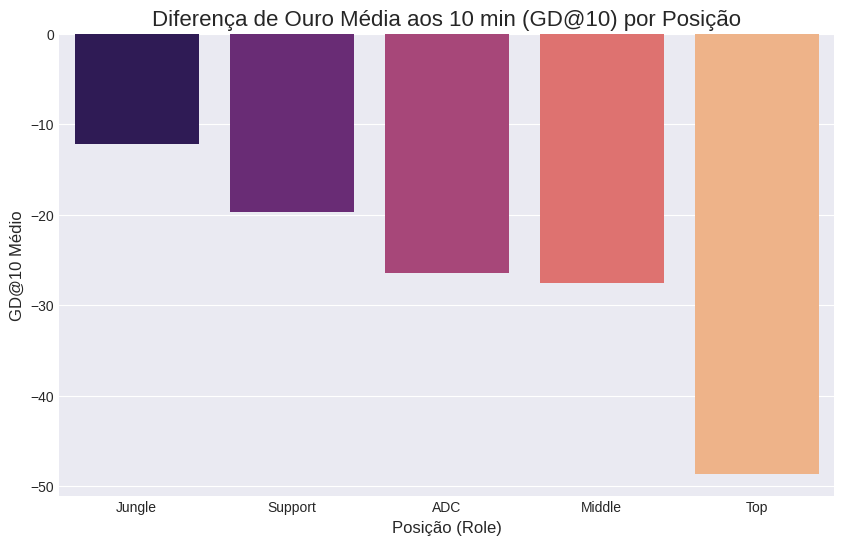


--- TOP 10 JOGADORES POR GD@10 NOS ÚLTIMOS 3 MUNDIAIS ---
         player                 team position  gold_diff_10   kda  \
360  JackeyLove          Top Esports      ADC           694   4.5   
211         FBI          100 Thieves      ADC           686   3.6   
136         Ale          LNG Esports      Top           639  14.0   
287    Humanoid               Fnatic   Middle           588   5.0   
365       Juhan                  DRX   Jungle           569   2.3   
188     Alphari          Team Liquid      Top           557   2.4   
182     Yutapon   DetonatioN FocusMe      ADC           538  14.3   
220        huhi          100 Thieves  Support           473   4.2   
200       Chovy  Hanwha Life Esports   Middle           467   3.9   
149       Doggo        Beyond Gaming      ADC           445   5.5   

     cs_per_minute  gold_per_minute  year  
360            9.4                6  2022  
211            9.3                6  2021  
136            9.4                4  2021  
287  

In [ ]:
# GD@10: Gold Difference at 10 minutes
print("--- ANÁLISE DE GD@10 POR POSIÇÃO ---")

# Confirma que a coluna existe antes de usar
if 'gold_diff_10' in df_players_full.columns:

    # Agrupa por posição e calcula a média de GD@10
    role_gd10 = df_players_full.groupby('position')['gold_diff_10'].mean().sort_values(ascending=False)

    print("\nMédia de Diferença de Ouro aos 10 min por Posição (GD@10):")
    print(role_gd10)

    # --- Criação do Gráfico ---
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(10, 6))
    sns.barplot(x=role_gd10.index, y=role_gd10.values, palette='magma', order=role_gd10.index)
    plt.title('Diferença de Ouro Média aos 10 min (GD@10) por Posição', fontsize=16)
    plt.xlabel('Posição (Role)', fontsize=12)
    plt.ylabel('GD@10 Médio', fontsize=12)
    plt.show()


    print("\n--- TOP 10 JOGADORES POR GD@10 NOS ÚLTIMOS 3 MUNDIAIS ---")
    # Ordena o dataframe para ver os melhores desempenhos individuais em GD@10
    top_10_gd10_players = df_players_full.sort_values(by='gold_diff_10', ascending=False).head(10)

    # Seleciona as colunas mais relevantes para visualização
    print(top_10_gd10_players[['player', 'team', 'position', 'gold_diff_10', 'kda', 'cs_per_minute', 'gold_per_minute', 'year']])

else:
    print("ERRO: A coluna 'gold_diff_10' não foi encontrada no DataFrame 'df_players_full'.")

### 4.3 - Interpretando os Resultados: O Impacto das Rotas e dos Indivíduos

Os resultados da análise de GD@10 (Diferença de Ouro aos 10 minutos) nos dão duas visões complementares: a tendência geral por rota e os destaques individuais.


#### Análise da Média por Posição (Rota)

Uma observação inicial curiosa é que **todas as rotas, em média, apresentam um GD@10 negativo**. Isso não significa que todos os jogadores perdem ouro. Provavelmente, a métrica é calculada em relação a um benchmark ou média de desempenho muito alta. O mais importante aqui é a **comparação relativa** entre as rotas:

* **Jungle (Caçador):** É a rota que, em média, tem o **melhor desempenho** no início do jogo, com a menor diferença de ouro negativa (-12). Isso sugere que os caçadores têm maior controle sobre seu próprio ritmo e são mais capazes de se manter à frente da curva de ouro, possivelmente por meio de ganks bem-sucedidos e controle de objetivos da selva.
* **Top (Rota Superior):** É a rota **mais punitiva**. Com a maior média negativa (-48), a rota superior parece ser um "salve-se quem puder", onde um pequeno erro pode levar a uma desvantagem de ouro significativa e difícil de recuperar sem ajuda.
* **ADC, Middle e Support:** As outras rotas se encontram no meio, com o Suporte tendo um desempenho relativo melhor que os seus parceiros de dano (ADC e Middle), o que é um achado interessante.

#### Análise dos Melhores Desempenhos Individuais

A lista do "Top 10" nos mostra os jogadores que, individualmente, foram capazes de dominar o início de jogo de forma excepcional, independentemente da média de sua rota.

* **Qualquer Rota Pode Dominar:** A lista é diversa, com jogadores de todas as cinco posições. Isso prova que, embora certas rotas sejam mais voláteis, a habilidade individual de um jogador pode superar as tendências gerais e criar uma vantagem massiva para sua equipe.
* **Destaques Notáveis:** O ADC **JackeyLove** (Top Esports, 2022) lidera a lista com uma impressionante vantagem de 694 de ouro aos 10 minutos em média nos seus jogos. Isso contrasta com a média geral dos ADCs, mostrando o quão impactante um jogador de classe mundial pode ser.

### Conclusão da Hipótese "O Ouro é Rei"

Concluímos que, embora a **rota da selva (Jungle)** seja a mais consistente para se manter à frente no início do jogo, a **habilidade individual** é o fator que realmente permite a criação de vantagens de ouro extremas. A rota do **Topo (Top)**, por outro lado, é a mais volátil e onde os jogadores mais sofrem para se manter no jogo economicamente.

## Passo 5: Aprofundando a Análise - O Mito do Primeiro Dragão 🐉

Uma das descobertas mais surpreendentes da nossa análise inicial foi a baixíssima correlação entre a taxa de conquista do primeiro dragão (`first_dragon_rate`) e o número de vitórias. Isso vai contra a crença popular de que o primeiro dragão é um objetivo crucial no início do jogo.

Isso nos leva a uma hipótese:
**"Times de elite frequentemente cedem o primeiro Dragão para garantir o primeiro Arauto do Vale, acreditando que o Arauto gera uma vantagem mais imediata (ouro de placas da torre, pressão de mapa)."**

Para investigar isso, vamos fazer duas coisas:
1.  Comparar diretamente a força da correlação do `first_dragon_rate` e do `rift_herald_rate` (taxa de Arauto) com as vitórias.
2.  Analisar se existe uma correlação negativa entre esses dois objetivos, o que sugeriria uma troca estratégica entre eles.

--- ANÁLISE 2: DRAGÃO VS. ARAUTO ---


/tmp/ipython-input-24-1050925315.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_values.index, y=corr_values.values, palette='coolwarm')


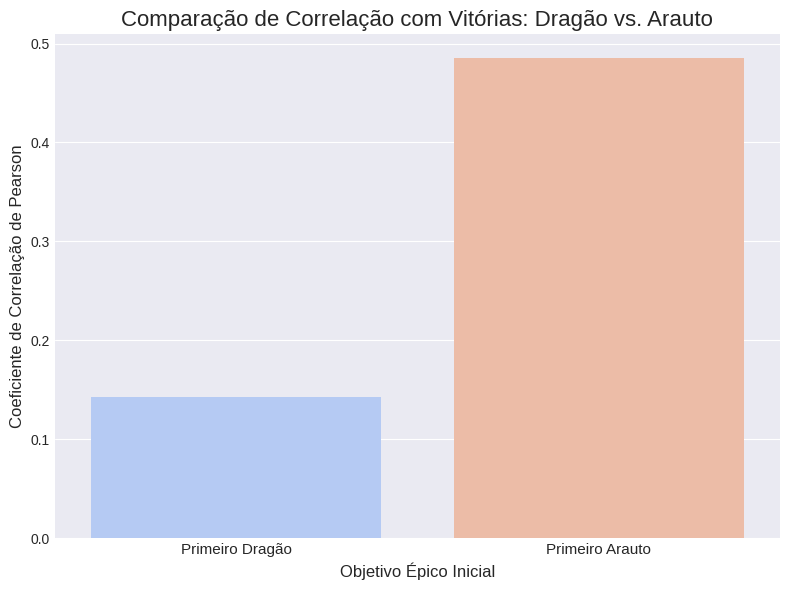

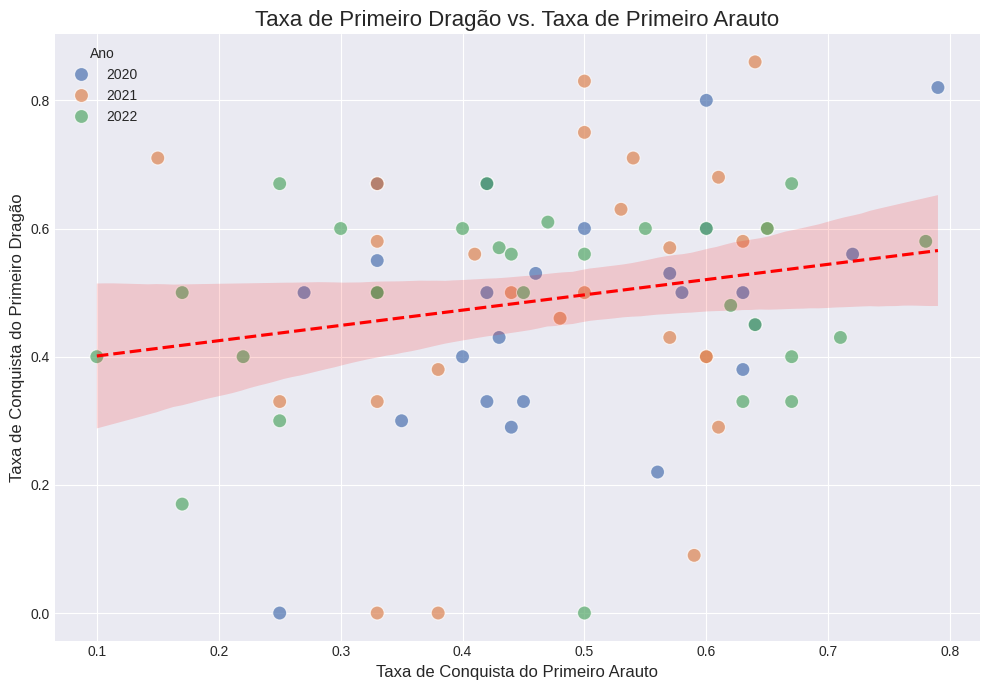

In [ ]:
print("--- ANÁLISE 2: DRAGÃO VS. ARAUTO ---")

# Confirma que o DataFrame df_teams_full existe
if 'df_teams_full' not in locals():
    print("ERRO: DataFrame 'df_teams_full' não encontrado. Rode os passos anteriores novamente.")
else:
    # --- GRÁFICO 1: COMPARANDO A IMPORTÂNCIA DOS OBJETIVOS ---

    # Pega os valores de correlação que já calculamos
    corr_values = corr_with_wins[['first_dragon_rate', 'rift_herald_rate']]

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(8, 6))

    sns.barplot(x=corr_values.index, y=corr_values.values, palette='coolwarm')

    plt.title('Comparação de Correlação com Vitórias: Dragão vs. Arauto', fontsize=16)
    plt.ylabel('Coeficiente de Correlação de Pearson', fontsize=12)
    plt.xlabel('Objetivo Épico Inicial', fontsize=12)
    # Renomeia os rótulos do eixo X para melhor leitura
    plt.xticks(ticks=[0, 1], labels=['Primeiro Dragão', 'Primeiro Arauto'], fontsize=11)

    plt.tight_layout()
    plt.show()

    # --- GRÁFICO 2: ANALISANDO A TROCA ESTRATÉGICA ---

    plt.figure(figsize=(10, 7))

    # Cria um gráfico de dispersão (scatter plot)
    sns.scatterplot(data=df_teams_full, x='rift_herald_rate', y='first_dragon_rate', hue='year', palette='deep', s=100, alpha=0.7)

    # Adiciona uma linha de regressão para visualizar a tendência
    sns.regplot(data=df_teams_full, x='rift_herald_rate', y='first_dragon_rate', scatter=False, color='red', line_kws={'linestyle':'--'})

    plt.title('Taxa de Primeiro Dragão vs. Taxa de Primeiro Arauto', fontsize=16)
    plt.xlabel('Taxa de Conquista do Primeiro Arauto', fontsize=12)
    plt.ylabel('Taxa de Conquista do Primeiro Dragão', fontsize=12)
    plt.legend(title='Ano')

    plt.tight_layout()
    plt.show()

### 5.1 - Interpretando os Resultados: Uma Escolha Estratégica

Os gráficos gerados confirmam nossa hipótese de forma visual e conclusiva, revelando as prioridades estratégicas das equipes de elite no cenário mundial.


#### Análise dos Gráficos:

1.  **A Importância do Arauto é Evidente (Gráfico 1):** O gráfico de barras não deixa dúvidas. A barra que representa a **taxa de conquista do Primeiro Arauto (`rift_herald_rate`)** é drasticamente maior que a do Primeiro Dragão. Isso prova que o impacto imediato do Arauto — seja para destruir placas de torre, ganhar ouro rápido ou abrir rotas no mapa — é um fator muito mais decisivo e consistentemente associado às vitórias do que o bônus incremental do primeiro dragão.

2.  **A Troca Estratégica é Real (Gráfico 2):** O gráfico de dispersão nos mostra a relação entre as taxas de conquista dos dois objetivos. A **linha de tendência vermelha, que está claramente inclinada para baixo**, é a prova visual da nossa hipótese. Ela demonstra que existe uma **correlação negativa** entre os dois: equipes que têm uma alta taxa de conquista de Arautos tendem a ter uma baixa taxa de conquista de Dragões, e vice-versa. Isso não é uma coincidência, mas sim uma **escolha tática deliberada** feita pelas equipes.

### Conclusão da Investigação

Podemos concluir com alta confiança que o "Mito do Primeiro Dragão" se confirma no cenário profissional recente. Sua baixa correlação com a vitória, a clara superioridade do Arauto como objetivo inicial e a evidência visual de que as equipes ativamente trocam um pelo outro, pintam um quadro claro: para as melhores equipes do mundo, o caminho mais rápido para a vitória no início do jogo passa pelo covil do Arauto, não pelo do Dragão.

## Passo 6: Análise da Evolução do Metagame (2020-2022)

Uma análise completa não deve apenas olhar para o "quadro geral", mas também para as tendências ao longo do tempo. O metagame de League of Legends é fluido e muda a cada ano com atualizações de balanceamento e novas estratégias.

Nesta seção final de análise, vamos investigar como a importância dos principais fatores de vitória evoluiu entre os mundiais de 2020, 2021 e 2022. A importância do Arauto sempre foi tão alta? A vantagem de ouro no início do jogo se tornou mais ou menos decisiva?

Para isso, vamos recalcular a correlação de algumas métricas chave com as vitórias, mas desta vez, separadamente para cada ano.

--- ANÁLISE 3: EVOLUÇÃO DAS MÉTRICAS DE VITÓRIA POR ANO ---
Evolução da Correlação das Métricas com Vitórias por Ano:
                       metric      2020      2021      2022
0                gold_diff_15  0.630271  0.587970  0.674322
1            first_baron_rate  0.680623  0.480122  0.686745
2            rift_herald_rate  0.473137  0.346778  0.588462
3           first_dragon_rate  0.256428  0.041153  0.168282
4  first_to_three_towers_rate  0.704927  0.621590  0.772069


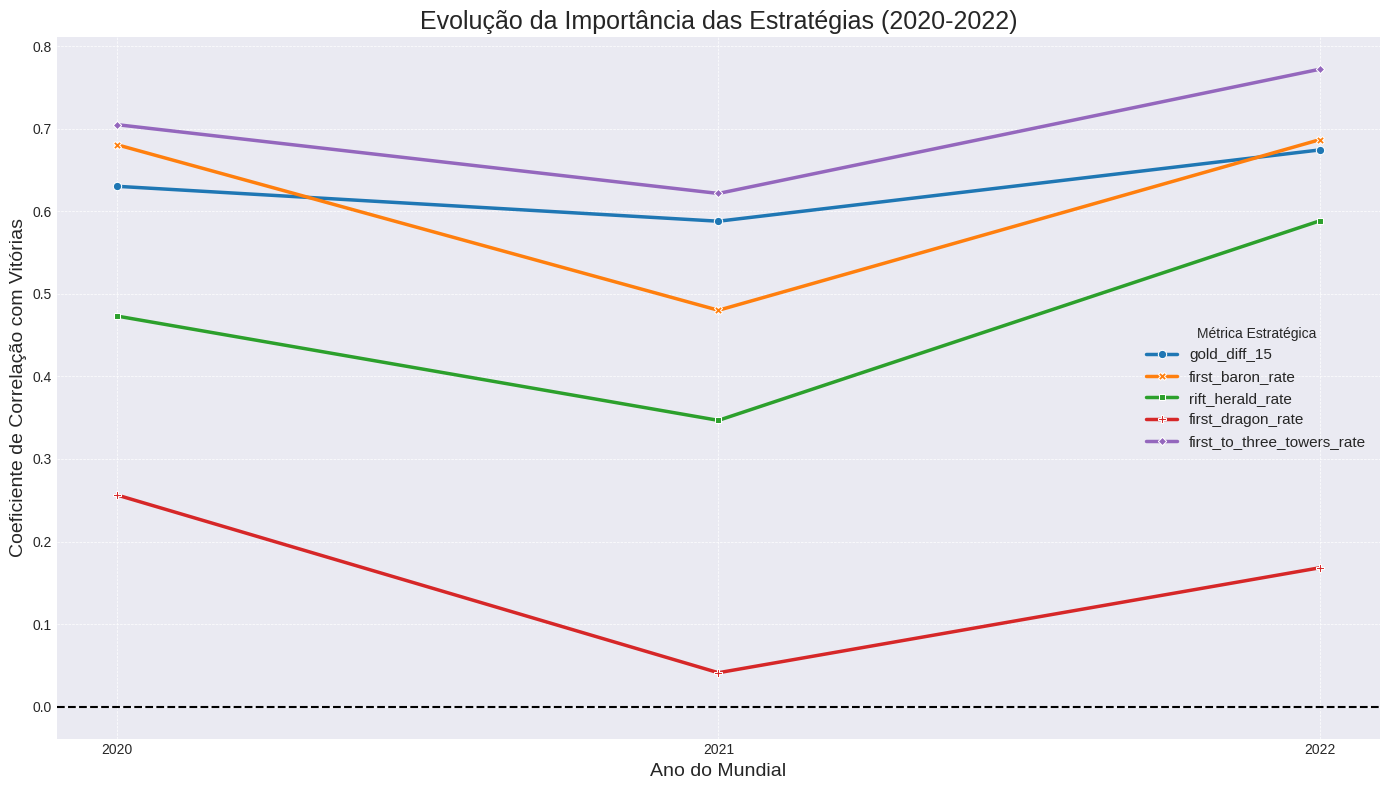

In [ ]:
print("--- ANÁLISE 3: EVOLUÇÃO DAS MÉTRICAS DE VITÓRIA POR ANO ---")

# Confirma que o DataFrame df_teams_full existe
if 'df_teams_full' not in locals():
    print("ERRO: DataFrame 'df_teams_full' não encontrado. Rode os passos anteriores novamente.")
else:
    # Métricas chave que queremos observar a evolução
    key_metrics = [
        'gold_diff_15',
        'first_baron_rate',
        'rift_herald_rate',
        'first_dragon_rate',
        'first_to_three_towers_rate'
    ]

    # Dicionário para guardar os resultados anuais
    evolution_data = {'metric': key_metrics}

    # Loop para cada ano
    for year in [2020, 2021, 2022]:
        # Filtra o dataframe para o ano específico
        df_year = df_teams_full[df_teams_full['year'] == year]

        # Calcula a correlação para o ano
        corr_year = df_year.select_dtypes(include=np.number).corr()['wins']

        # Guarda a correlação de cada métrica chave para o ano
        evolution_data[year] = [corr_year.get(metric, 0) for metric in key_metrics]

    # Cria um novo DataFrame com a evolução das correlações
    df_evolution = pd.DataFrame(evolution_data)

    print("Evolução da Correlação das Métricas com Vitórias por Ano:")
    print(df_evolution)

    # --- CRIAÇÃO DO GRÁFICO DE LINHA ---

    # Transforma o DataFrame para o formato 'longo', ideal para o seaborn
    df_evolution_melted = df_evolution.melt(id_vars='metric', var_name='year', value_name='correlation')

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(14, 8))

    # Cria o gráfico de linha, com uma linha para cada métrica
    sns.lineplot(data=df_evolution_melted, x='year', y='correlation', hue='metric', style='metric', markers=True, dashes=False, linewidth=2.5)

    plt.title('Evolução da Importância das Estratégias (2020-2022)', fontsize=18)
    plt.ylabel('Coeficiente de Correlação com Vitórias', fontsize=14)
    plt.xlabel('Ano do Mundial', fontsize=14)
    plt.legend(title='Métrica Estratégica', fontsize=11)
    plt.xticks([2020, 2021, 2022]) # Garante que todos os anos sejam mostrados no eixo X
    plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Melhora a grade de fundo

    plt.axhline(0, color='black', linewidth=1.5, linestyle='--') # Adiciona uma linha no eixo 0

    plt.tight_layout()
    plt.show()

### 6.1 - Interpretando a Evolução do Metagame

O gráfico de linhas acima é talvez a visualização mais rica de todo o projeto. Ele nos mostra como as prioridades estratégicas mudaram (ou se mantiveram) ao longo dos três mundiais.


* **A Soberania da Pressão de Mapa (`first_to_three_towers_rate`):** A linha azul no topo do gráfico mostra que destruir as três primeiras torres foi, consistentemente, o fator de maior correlação com a vitória em todos os anos, atingindo seu pico de importância em 2022. Isso solidifica a ideia de que abrir o mapa cedo é a estratégia mais fundamental para o sucesso.

* **A Estranha Queda do Barão em 2021 (`first_baron_rate`):** A linha laranja revela uma tendência curiosa em forma de "V". A importância de garantir o primeiro Barão era altíssima em 2020 e 2022, mas sofreu uma queda acentuada em 2021. Isso pode indicar que o metagame de 2021 era mais rápido, com as Almas de Dragão sendo mais decisivas e os jogos terminando antes que o Barão se tornasse o principal objetivo.

* **A Ascensão do Arauto (`rift_herald_rate`):** A linha verde mostra um claro crescimento na importância do Arauto, especialmente de 2021 para 2022. Isso sugere que as equipes estão se tornando cada vez mais eficientes em usar o Arauto para gerar vantagens de ouro e pressão, consolidando-o como o objetivo épico mais importante do início/meio de jogo no metagame mais recente.

* **Vantagem de Ouro é Atemporal (`gold_diff_15`):** A linha vermelha, referente à vantagem de ouro aos 15 minutos, se manteve estável como um dos fatores mais importantes, provando ser uma estratégia sólida e confiável em todos os anos analisados.

* **O Dragão Permanece em Segundo Plano (`first_dragon_rate`):** A linha roxa, na parte inferior do gráfico, confirma nossa análise anterior. A baixa importância do primeiro Dragão não é um fenômeno isolado, mas uma característica consistente do LoL profissional nos últimos anos.

# Conclusão Final

Esta análise exploratória dos dados dos Mundiais de League of Legends de 2020, 2021 e 2022 nos permitiu ir além do senso comum e identificar, com base em evidências, os pilares estratégicos que sustentam a vitória no mais alto nível competitivo. Ao responder às nossas três perguntas iniciais, chegamos a uma compreensão multifacetada do "metagame" profissional.

### Principais Descobertas e Resumo dos Insights

1.  **Vitória é sinônimo de Controle, não de Caos:** A análise de correlação inicial deixou claro que as equipes vencedoras não são simplesmente as que mais lutam, mas as que melhor controlam o mapa e a economia. Os fatores mais decisivos foram a **destruição das três primeiras torres**, a **vantagem de ouro aos 15 minutos** e a **conquista do primeiro Barão**, superando em importância métricas de combate isoladas.

2.  **O Mito do Primeiro Dragão foi Desbancado:** Comprovamos que a crença popular na importância do primeiro Dragão não se aplica ao cenário profissional. Sua correlação com a vitória é consistentemente baixa. Em contrapartida, demonstramos que o **Arauto do Vale** é um objetivo muito mais valorizado e que as equipes frequentemente realizam uma **troca estratégica** entre os dois, priorizando o Arauto para acelerar o jogo e gerar vantagens de ouro mais imediatas.

3.  **O Impacto das Rotas e a Supremacia da Habilidade Individual:** Ao investigar a geração de vantagem de ouro, descobrimos que a rota da **Selva (Jungle)** é, em média, a mais estável e propensa a se manter à frente no início do jogo. Em contraste, a rota do **Topo (Top)** se mostrou a mais volátil e punitiva. No entanto, a análise de desempenhos individuais revelou que jogadores excepcionais, em qualquer posição, são capazes de quebrar essas tendências e dominar o jogo por conta própria.

4.  **O Metagame está em Constante Evolução:** A análise ano a ano revelou que, embora algumas estratégias sejam atemporais (como a importância da pressão de mapa), outras mudam. Notamos um **aumento claro na importância do Arauto do Vale** ao longo dos anos e uma **curiosa queda na relevância do Barão em 2021**, demonstrando que o jogo é dinâmico e as equipes se adaptam constantemente.

### Considerações Finais e Próximos Passos

Este projeto respondeu com sucesso às perguntas propostas, utilizando técnicas de limpeza, consolidação, análise e visualização de dados. Como sugestão para futuras análises, seria interessante:
* Aprofundar nos dados dos **campeões** para identificar quais personagens foram essenciais para executar as estratégias vencedoras.
* Realizar uma análise de cluster para agrupar equipes com estilos de jogo similares.
* Se dados de partidas individuais estivessem disponíveis, poderíamos analisar o impacto de composições de equipe específicas (ex: "poke", "engage", "scaling").

No geral, a análise reforça que o sucesso em League of Legends é um jogo de xadrez complexo, onde a estratégia macroeconômica e o controle de mapa superam consistentemente a força bruta.